In [1]:
import numpy as np
from scipy.special import *
import matplotlib.pyplot as plt

In [143]:
int(9.6)

9

In [145]:
def Vmorse(R,De,Re,we):
    """Define the Morse potential with depth De, equilibrium position Re, typical width we as function of position R"""
    return De*(np.exp(-2*(R-Re)/we)-2*np.exp(-(R-Re)/we))

def omega_nu(lambd):
    "Gives the vector of the energies of the bound vibrational states"
    nuv = np.arange(int(lambd-0.5))
    return -(lambd-nuv-0.5)**2/lambd**2

In [151]:
v_nu = omega_nu(8.8)
v_mu = omega_nu(4.8)
N_nu=len(v_nu)
N_mu=len(v_mu)
np.outer(v_mu,np.ones(N_nu))-np.outer(np.ones(N_mu),v_nu)

array([[ 0.08707458, -0.1143717 , -0.28999153, -0.43978492, -0.56375187,
        -0.66189236, -0.73420641, -0.78069401],
       [ 0.41693569,  0.21548941,  0.03986958, -0.10992381, -0.23389075,
        -0.33203125, -0.4043453 , -0.4508329 ],
       [ 0.65999125,  0.45854497,  0.28292513,  0.13313174,  0.0091648 ,
        -0.08897569, -0.16128974, -0.20777735],
       [ 0.81624125,  0.61479497,  0.43917513,  0.28938174,  0.1654148 ,
         0.06727431, -0.00503974, -0.05152735]])

In [19]:
def psiR(R,lambd,nu,Re,we,norm=0):
    "Gives the eigenfunction of mode nu as function of radial coordinate R for a Morse potentialgiven by Re and we"
    "lambd is sqrt(2*m*De)*we/hbar"
    zv=2*lambd*np.exp(-(R-Re)/we)
    "z is the coordinate in which the Schroedinger equation is solver"
    psi = psiz(zv,lambd,nu)
    N = np.sqrt(np.sum(np.conjugate(psi)*psi))
    if norm==0:
        return psi#/np.sqrt(we)
    else:
        return psi/N

def psiz(z,lambd,nu):
    "Gives the NON-normalized wavefunction of mode nu as function of the new coordinate z"
    N=np.sqrt((2*lambd-2*nu-1)*factorial(nu)/gamma(2*lambd-nu))
    return np.exp(-z/2)*genlaguerre(nu,2*lambd-2*nu-1)(z)*z**(lambd-nu-1/2)#*N

In [5]:
def Afc(lambd1,Re1,we1,lambd2,Re2,we2):
    "Gives a matrix (table) with the Franck-Condon factors between the vibrational levels of two different Morse potentials"
    "The Morse potentials are characterized by different lambda (i.e. De), Re and we"
    "Returns a matrix array with the Franck-Condon factors between all the vibrational levels"
    nuM1=int(np.floor(lambd1-0.5)) #find max number of levels for Morse 1"
    nuM2=int(np.floor(lambd2-0.5)) #find max number of levels for Morse 2"
    Amunu=np.zeros((nuM1+1,nuM2+1))
    Rv = np.linspace(0,50*max(we1,we2)+max(Re1,Re2),10000) #define vector of coordinates"
    for nu1 in range(nuM1+1):
        psi1 = psiR(Rv,lambd1,nu1,Re1,we1) #get eigenfunction 1"
        N1 = np.sum(psi1*np.conjugate(psi1)) #and its normalization"
        for nu2 in range(nuM2+1):
            psi2 = psiR(Rv,lambd2,nu2,Re2,we2) #"get eigenfunction 2"
            N2 = np.sum(psi2*np.conjugate(psi2)) #"and its normalization"
            Amunu[nu1,nu2] = np.sum(psi1*psi2)/np.sqrt(N1*N2) #"compute overlap"
    return Amunu

def AfcDipole(lambd1,Re1,we1,lambd2,Re2,we2):
    "Gives a matrix (table) with the dipole matrix elements between the vibrational levels of two different Morse potentials"
    "The Morse potentials are characterized by different lambda (i.e. De), Re and we"
    "Useful to calculate molecular-dipole induced transitions"
    nuM1=int(np.floor(lambd1-0.5)) #find max number of levels for Morse 1"
    nuM2=int(np.floor(lambd2-0.5)) #find max number of levels for Morse 2"
    Amunu=np.zeros((nuM1+1,nuM2+1))
    Rv = np.linspace(0,50*max(we1,we2)+max(Re1,Re2),10000) #define vector of coordinates"
    for nu1 in range(nuM1+1):
        psi1 = psiR(Rv,lambd1,nu1,Re1,we1) #get eigenfunction 1"
        N1 = np.sum(psi1*np.conjugate(psi1)) #and its normalization"
        for nu2 in range(nuM2+1):
            psi2 = psiR(Rv,lambd2,nu2,Re2,we2) #"get eigenfunction 2"
            N2 = np.sum(psi2*np.conjugate(psi2)) #"and its normalization"
            Amunu[nu1,nu2] = np.sum(psi1*Rv*psi2)/np.sqrt(N1*N2) #"compute overlap"
    return Amunu

In [5]:
def psiE(R,E,lambd,Re,we):
    "Numerically solve the Schroedinger equation for unbound states with energy E (measured in units of De)"
    "The parameters lambd, Re and we characterize the Morse potential"
    "First define a suitable range of coordinates R"
    Ns = 10000
    Rv = np.linspace(0,50*we+Re,Ns)
    h = (50*we+Re)/Ns
    "Then define the vector k(r) for the Numerov method. Use the Morse potential with right parameters and De=1"
    VMv = Vmorse(Rv,1,Re,we)
    kv = np.sqrt(E-np.array(VMv,dtype=complex))*lambd/we
    "Then impose the boundary conditions on the wavefunction at large R"
    psiv1 = np.zeros(Ns,dtype=complex)
    psiv1[Ns-1] = 1
    psiv1[Ns-2] = 1-1j*h*kv[Ns-1]
    psiv2 = np.zeros(Ns,dtype=complex)
    psiv2[Ns-1] = 1
    psiv2[Ns-2] = 1+1j*h*kv[Ns-1]
    for i in np.arange(0,Ns-2):
        psiv1[Ns-3-i] = (2*psiv1[Ns-i-2]*(1-5*h**2*kv[Ns-i-2]**2/12)-psiv1[Ns-i-1]*(1+h**2*kv[Ns-i-1]**2/12))/(1+h**2*kv[Ns-i-3]**2/12)
        psiv2[Ns-3-i] = (2*psiv2[Ns-i-2]*(1-5*h**2*kv[Ns-i-2]**2/12)-psiv2[Ns-i-1]*(1+h**2*kv[Ns-i-1]**2/12))/(1+h**2*kv[Ns-i-3]**2/12)
    return psiv1,psiv2,kv
        

In [8]:
def psiE2(R,E,lambd,Re,we):
    "Numerically solve the Schroedinger equation for unbound states with energy E (measured in units of De)"
    "The parameters lambd, Re and we characterize the Morse potential"
    "First define a suitable range of coordinates R"
    Ns = 10000
    Rv = np.linspace(0,20*we+Re,Ns)
    h = (50*we+Re)/Ns
    "Then define the vector k(r) for the Numerov method. Use the Morse potential with right parameters and De=1"
    VMv = Vmorse(Rv,1,Re,we)
    kv = np.sqrt(E-np.array(VMv,dtype=complex))*lambd/we
    "Then impose the boundary conditions on the wavefunction at large R"
    psiv1 = np.zeros(Ns,dtype=complex)
    psiv1[0] = np.exp(1j*kv[0])
    psiv1[1] = np.exp(1j*kv[1])
    for i in np.arange(1,Ns-1):
        psiv1[i+1] = (2*psiv1[i]*(1-5*h**2*kv[i]**2/12)-psiv1[i-1]*(1+h**2*kv[i-1]**2/12))/(1+h**2*kv[i+1]**2/12)
    #psiv2 = np.zeros(Ns,dtype=complex)
    #psiv2[0] = 1j*np.exp(1j*kv[0])
    #psiv2[1] = 1j*np.exp(1j*kv[1])
    #for i in np.arange(1,Ns-1):
    #    psiv2[i+1] = (2*psiv2[i]*(1-5*h**2*kv[i]**2/12)-psiv2[i-1]*(1+h**2*kv[i-1]**2/12))/(1+h**2*kv[i+1]**2/12)
    return psiv1/np.max(psiv1),kv,Rv

In [115]:
def Ec_filter(Et,tv,r,wc):
    Nt = len(tv)
    Nr = -int(10/np.log(r))
    dt = tv[1]-tv[0]
    dn = np.pi/(dt*wc)
    out = np.zeros(Nt,dtype=complex)
    for n in np.arange(Nr):
        Eshift = np.zeros(Nt,dtype=complex)
        Dn = int(dn*n)
        if Dn<Nt:
            Eshift[Dn:] = Et[:Nt-Dn]
            out = out +(-r)**n*Eshift
    return out
    
def Ec_Gaussian(tv,wL,tau,wc,r):
    Nr = -int(10/np.log(r))
    out = np.zeros(len(tv),dtype=complex)
    for n in range(Nr):
        out = out + (-r)**n*np.exp(-1j*wL*(tv-n*np.pi/wc))*np.exp(-(tv-n*np.pi/wc)**2/tau**2)
    return out

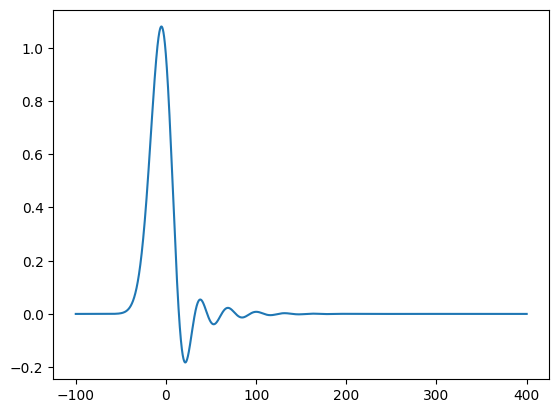

In [138]:
tv=np.linspace(-100,400,20000)
Et=Ec_Gaussian(tv,0.8,20,1,0.9)
plt.plot(tv,Et*np.exp(1j*0.8*tv))

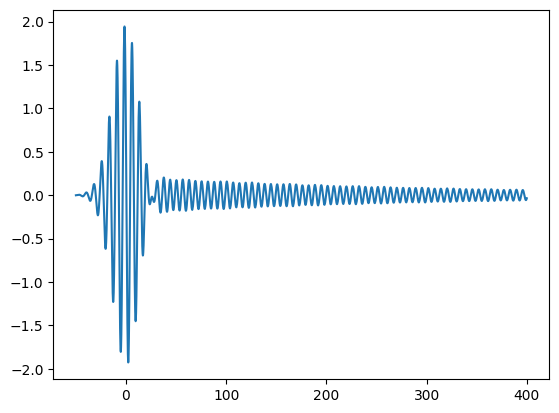

In [123]:
plt.plot(tv,Ec_filter(Et,tv,0.99,1))
#plt.xlim([50,100])

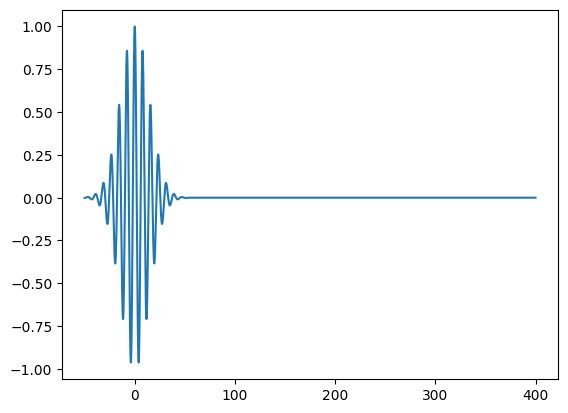

In [120]:
tv=np.linspace(-50,400,20000)
Et=np.exp(-1j*0.8*tv)*np.exp(-tv**2/400)
plt.plot(tv,Et)

In [168]:
def evol_matr(tvec,El,omega_mu,omega_nu,Amunu,gmunu):
    N_mu = len(omega_mu)
    N_nu = len(omega_nu)
    size = (N_mu+1)*(N_nu+1)-1
    Nt = len(tvec)
    matr = np.zeros((Nt,size,size))
    for t in range(Nt):
        OmR = Amunu*np.exp(1j*(np.outer(vmu,np.ones(N_nu))-np.outer(np.ones(N_mu),vnu)*tvec[t]))*El[t]
        matr[t,:N_mu,N_mu:N_mu+N_nu] = gmunu
        matr[t,N_mu:N_mu+N_nu,N_mu:N_mu+N_nu] = -np.diag(np.sum(gmunu,0))
        matr[t,N_mu+N_nu:,N_mu+N_nu:] = -np.diag(np.sum(gmunu,0),np.ones(N_mu))/2
    return matr

In [ ]:
"From this point on it's kinda garbage tests"

In [167]:
vmu=np.arange(10)
vnu=np.sqrt(np.arange(6))
gmunu = np.outer(vmu,vnu)
np.diag(np.kron(np.sum(gmunu,0),np.ones(2)))

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  45.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  45.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         63.63961031,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,

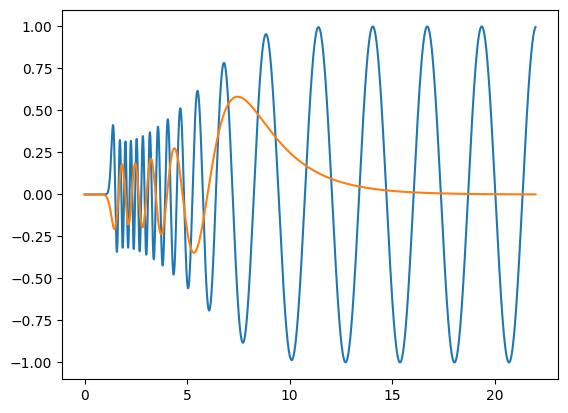

In [43]:
plt.plot(Rv,np.real(psi2),Rv,np.real(psi0/N0))#,Rv,Vmorse(Rv,1,2,1))
#plt.ylim([-0.2,1])
#plt.xlim([0,2])
plt.show()

In [45]:
np.sum(psi1*psi0)/len(psi1)

(-0.0013388187525439428+0j)

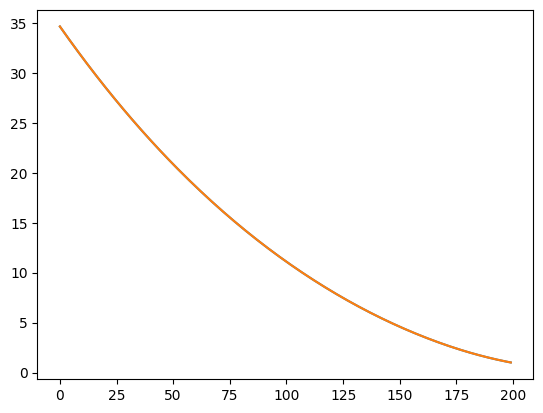

In [75]:
plt.plot(np.real(np.log(psi1[:200])))
plt.plot(np.real(np.log(psi2[:200])))

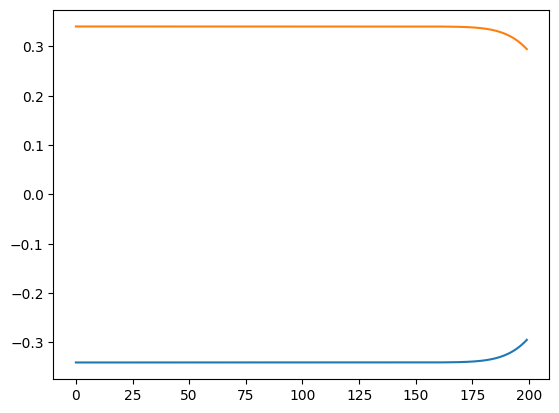

In [79]:
plt.plot(np.imag(np.log(psi1[:200])))
plt.plot(np.imag(np.log(psi2[:200])))

6.7835523330299115

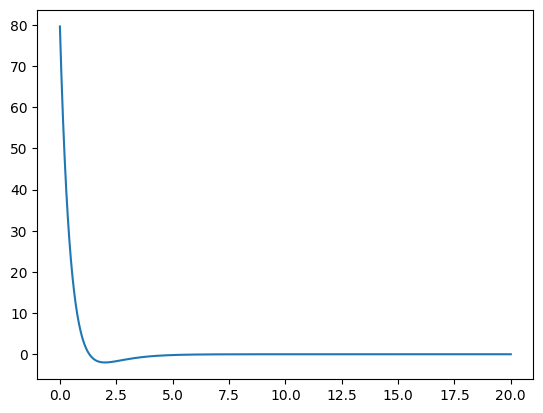

In [36]:
xv=np.linspace(0,20,2000)
plt.plot(xv,Vmorse(xv,2,2,1))
Vmorse(0.305,2,2,1.5)

In [5]:
Afc(10.2,1,0.5,4.8,1.5,0.8)

array([[ 0.30248104, -0.36568951,  0.33794774, -0.2604567 ,  0.12542701],
       [ 0.39478592, -0.32423987,  0.19619158, -0.09965232,  0.03686586],
       [ 0.48230689, -0.23526562,  0.0446989 ,  0.03132354, -0.02690032],
       [ 0.48041424,  0.00421839, -0.18557686,  0.18079643, -0.09018857],
       [ 0.41898318,  0.26273041, -0.28079723,  0.16135977, -0.06148465],
       [ 0.29297491,  0.47654448, -0.17663068, -0.01147653,  0.03165838],
       [ 0.15878555,  0.51138022,  0.17300273, -0.2441452 ,  0.11918096],
       [ 0.05105787,  0.36392808,  0.5372147 , -0.19525599,  0.03799671],
       [ 0.00471137,  0.12511997,  0.58621579,  0.33325965, -0.17587398],
       [-0.00141794, -0.00460837,  0.18277874,  0.79461962,  0.12942202]])

In [16]:
xv=np.linspace(0,10,20000)
np.sum(psiR(xv,10,0,1,1)*psiR(xv,10,0,1,1))*10/20000

6402053525340645.0

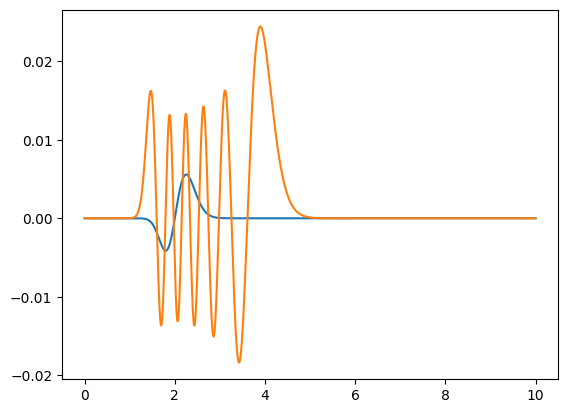

In [26]:
xv=np.linspace(0,10,20000)
Re=2
we=1
#plt.plot(xv,psiR(xv,20.6,20,Re,we),xv,Vmorse(xv,1,Re,we))
#plt.plot(xv,psiR(xv,20,0,Re+1,we)+2,xv,Vmorse(xv,1,Re+1,we)+2)
plt.plot(xv,(xv-Re)*psiR(xv,20,0,Re,we,norm=1),xv,psiR(xv,20,10,Re,we,norm=1))
#plt.ylim([-2,4])

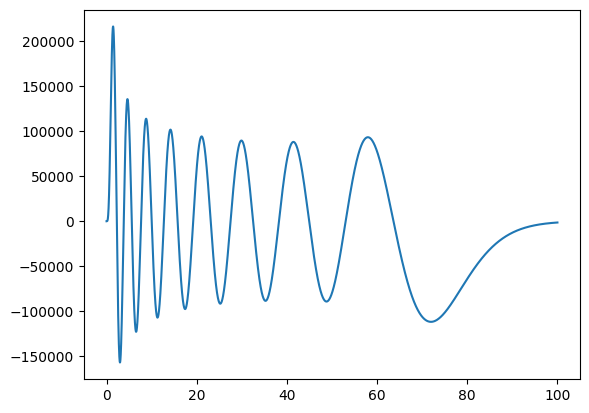

In [8]:
xv=np.linspace(0,100,20000)
plt.plot(xv,psiz(xv,20,15))